In [2]:
!pip install natasha -q

Приложил к 1 лекции все методички по курсу

**

Домашнее задание 2 варианта на выбор:
1 вариант (более легкий ) по ссылке https://gbcdn.mrgcdn.ru/uploads/asset/2800508/attachment/447973cb1f55a137a8a7eb4b175f4b47.pdf
2 вариант (рекомендую его, он более объемный, но и больше навыков отрабатывается) по описанию ниже:
все материалы для выполения дз в sem2.ipynb он находится в архиве Lesson-2.zip
для скачивания данных пользуйтесь этими ссылками

https://disk.yandex.ru/i/v5HM-ENiGXZVpQ
https://disk.yandex.ru/i/koR5eMCToCZS2Q

Задание 1.
Задание: обучите три классификатора:

1) на токенах с высокой частотой. ([ :N] частотных слов)

2) на токенах со средней частотой ( [N:N+X] частотных слов)

3) на токенах с низкой частотой( [N+X :] частотных слов)


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Задание 2.
найти фичи с наибольшей значимостью, и вывести их

Задание 3.
1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from string import punctuation
from stop_words import get_stop_words
from pymorphy3 import MorphAnalyzer
import re
import nltk


nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 120)
pd.set_option('display.width', 100)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('styler.latex.multicol_align',  'naive-l')
pd.set_option('display.colheader_justify', 'left')

## Прогрузка данных

In [5]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/koR5eMCToCZS2Q'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('positive.csv', 'wb') as f:
    f.write(download_response.content)

public_key = 'https://disk.yandex.ru/i/koR5eMCToCZS2Q'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('negative.csv', 'wb') as f:
    f.write(download_response.content)

In [6]:
positive_2 = pd.read_csv('positive.csv', sep=';', header= None)
positive_2.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,1,0,1,0,1273,26,27,0


In [7]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'], header= None) # заголовков в csv нет  -header= None калонка с нужным текстом 3 usecols=[3]
positive['label'] =  1
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'], header= None)
negative['label'] = 0
df = pd.concat([negative,positive], axis=0 )

df = df.sample(frac=1).reset_index(drop=True) #шафлим что бы данные не шли друг за другом для наглядности


In [8]:
df.head(90)

,text,label
0,@rapiluxa поздравляю тебя. мы уже 10 месяцев вместе:) люблю тебя:) \n10-это вечность,1
1,"RT @ILONAPilipenko: @swagarin не беспокойся, цвет постепенно смывается, не вредно это)",1
2,"поразило, когда беркут подъехал штурмовать кмда, со стороны Крещатика подошли Люди...и вломили им хорошей пиздяки. б...",0
3,"RT @LinUndead: @_PerfectDenial_ ОЙ,КАКТУСИК,ТЫ ШТОО\nДАВАЙ ПОПРААВЛЯЙСЯ,НАМ БОЛЬНЫЕ НЕ НУЖНЫ!!!\nВЫЗДОРААВЛИВАЙ:*",1
4,"@LarryInMy_Heart без всяких вопросов !) прочла твиты мяса,сижу -ржу",1
...,...,...
85,"@dudinskiy ох, еклмн! Ты имя что ли сменил? Смотри, а то так и до смены пола и, что хуже, клуба дойдет! ;-)",0
86,"RT @oblivionx86: В природе есть трое существ, которые при -25°С никогда не мёрзнут:\n1) пингвины;\n2) белые медведи;...",1
87,"Залезла в тви и поняла, что я забыла загадать желание, пиздец память:)",1
88,"@BirdParadise17 обожаю слушать музыку и рассматривать людей, предполагая кем они являются, и как складывается их жизнь)",0


## Препроцесинг


In [9]:

emoticon_dict = {'\(+': ' грустно', '\)+': ' счастлив', ' ax+': 'счастлив', ':D': 'счастлив'} # \S+ не пробелы
df['text']= df['text'].replace(emoticon_dict, regex=True)

df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
df.head()

,text,label
0,@rapiluxa поздравляю тебя. мы уже 10 месяцев вместе: счастлив люблю тебя: счастлив 10-это вечность,1
1,"RT @ILONAPilipenko: @swagarin не беспокойся, цвет постепенно смывается, не вредно это счастлив",1
2,"поразило, когда беркут подъехал штурмовать кмда, со стороны Крещатика подошли Люди...и вломили им хорошей пиздяки. б...",0
3,"RT @LinUndead: @_PerfectDenial_ ОЙ,КАКТУСИК,ТЫ ШТОО ДАВАЙ ПОПРААВЛЯЙСЯ,НАМ БОЛЬНЫЕ НЕ НУЖНЫ!!! ВЫЗДОРААВЛИВАЙ:*",1
4,"@LarryInMy_Heart без всяких вопросов счастлив прочла твиты мяса,сижу -ржу",1


In [10]:
sw = list(set(get_stop_words("ru")))

exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
  
    txt = str(txt)
    
    txt = re.sub(r'#\S+', '', txt) # удалит хештеги  
    txt = re.sub(r'@\S+', '', txt) # удалит упоминани 
    txt = re.sub(r'\d', '', txt) # удалит упоминани 
    txt = re.sub('http\S+\s*', '', txt) # удалит URL  
    txt = re.sub('RT|cc', '', txt) # удалит RT и cc

    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub('\s+', ' ', txt) # заменит пробельные символы на 1 пробел 
    
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df['text'] = df['text'].apply(preprocess_text)

In [11]:
df.head(4)

,text,label
0,поздравлять месяц вместе счастливый любить счастливый вечность,1
1,беспокоиться цвет постепенно смываться вредный счастливый,1
2,поразить беркут подъехать штурмовать кмд сторона крещатик подойти людия вломить хороший пиздяк беркут буля шоцi счас...,0
3,ойкактусикт штоо давать попраавляйсян больной нужный выздораавливать,1


In [12]:
corpus = [token for tweet in df['text']
          for token in nltk.tokenize.word_tokenize(tweet)]
print(len(corpus))
corpus[97:105]

1599216


['логарифмылюбить',
 'литература',
 'счастливый',
 'сопричастный',
 'поздравлять',
 'всемирный',
 'день',
 'футбол']

In [13]:
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('счастливый', 243282),
 ('знать', 6426),
 ('любить', 6152),
 ('хотеть', 6108),
 ('хороший', 6010),
 ('новый', 5356),
 ('мой', 4886),
 ('смотреть', 4686),
 ('день', 4534),
 ('завтра', 3954)]

In [14]:
len_courpus = int(len(freq_dict))
the_third = int(round(len(freq_dict)/3))
two_third = int(the_third*2)
len_courpus, the_third, two_third

(103514, 34505, 69010)

In [15]:
most_frequent_tokens = [item[0] for item in freq_dict.most_common(len_courpus)][:the_third]
avg_frequent_tokens = [item[0] for item in freq_dict.most_common(len_courpus)][the_third:two_third]
less_frequent_tokens = [item[0] for item in freq_dict.most_common(len_courpus)][two_third:]
all_tokens = [item[0] for item in freq_dict.most_common(len_courpus)]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state=42, stratify=df['label'])

In [179]:
import matplotlib.pyplot as plt

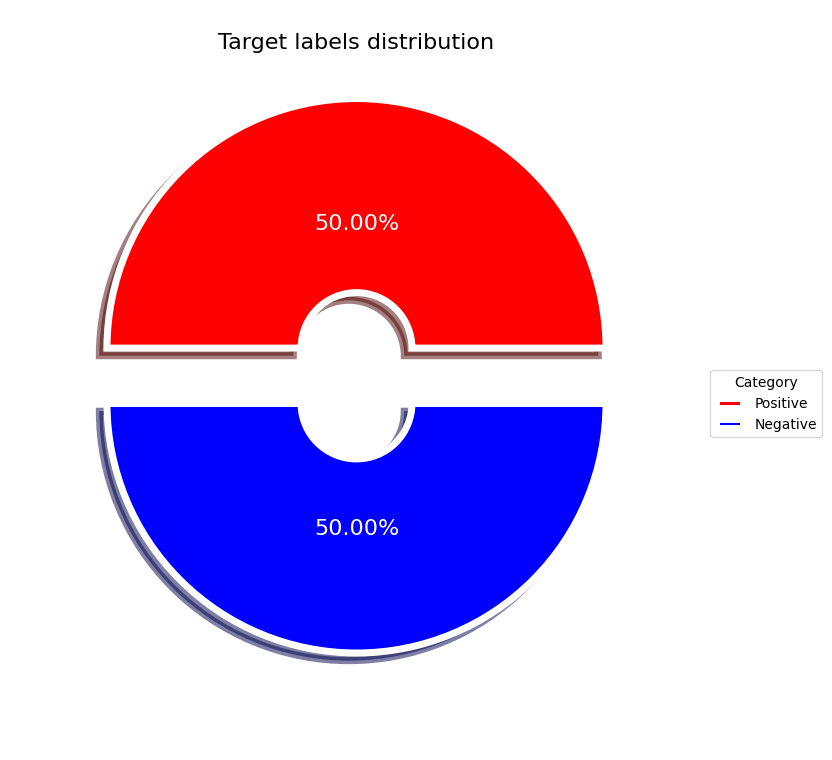

In [180]:
plt.subplots(figsize=(9, 9))

labels = "Positive","Negative"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df[df["label"]==1]["label"]),
                                    len(df[df["label"]==0]["label"])],
                                    explode = (0.2,0),
                                    textprops=dict(size= 16, color= "white"), # размер и цвет текста внутри диаграмы
                                    autopct="%.2f%%",
                                    pctdistance = 0.5, # положение текста значение процентов
                                    radius=0.9,
                                    shadow = True, # добовляет эфект тени к диаграме
                                    wedgeprops=dict(width = size, edgecolor = "white",
                                    linewidth = 5), # круг добовляет в центре
                                    startangle = 0, colors= ['red', 'blue'])

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nTarget labels distribution",fontsize=16)
plt.show()

In [181]:
min_samples_split_1 = round(len(df.index)*0.05) # при достижении 5 % данныъ в узле перестаем строить строить дерево
min_samples_split_1

11491

## Поиск по наиболее частым словам

In [182]:
%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, vocabulary=most_frequent_tokens)
X_train_transform = vec.fit_transform(X_train)
forest = DecisionTreeClassifier(criterion='gini', min_samples_split=min_samples_split_1)
forest.fit(X_train_transform, y_train)
pred = forest.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

CPU times: total: 0 ns
Wall time: 0 ns
              precision    recall  f1-score   support

           0       0.27      0.28      0.28     27983
           1       0.30      0.29      0.30     29473

    accuracy                           0.29     57456
   macro avg       0.29      0.29      0.29     57456
weighted avg       0.29      0.29      0.29     57456



## Слова средней встречаемости

In [183]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, vocabulary=avg_frequent_tokens)
X_train_transform = vec.fit_transform(X_train)
forest = DecisionTreeClassifier(criterion='gini', min_samples_split=min_samples_split_1)
forest.fit(X_train_transform, y_train)
pred = forest.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.46      0.60     53417
           1       0.00      0.00      0.00      4039

    accuracy                           0.43     57456
   macro avg       0.43      0.23      0.30     57456
weighted avg       0.80      0.43      0.56     57456



## Наименее встречающиеся слова

In [184]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, vocabulary=less_frequent_tokens)
X_train_transform = vec.fit_transform(X_train)
forest = DecisionTreeClassifier(criterion='gini', min_samples_split=min_samples_split_1)
forest.fit(X_train_transform, y_train)
pred = forest.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.46      0.60     53335
           1       0.00      0.00      0.00      4121

    accuracy                           0.43     57456
   macro avg       0.43      0.23      0.30     57456
weighted avg       0.80      0.43      0.56     57456



## Все слова

In [186]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, vocabulary=all_tokens)
X_train_transform = vec.fit_transform(X_train)
forest = DecisionTreeClassifier(criterion='gini', min_samples_split=min_samples_split_1)
forest.fit(X_train_transform, y_train)
pred = forest.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.28      0.26      0.27     30671
           1       0.21      0.23      0.22     26785

    accuracy                           0.25     57456
   macro avg       0.25      0.24      0.24     57456
weighted avg       0.25      0.25      0.25     57456



In [209]:
coefs = forest.feature_importances_
top_coefs = np.argsort(coefs)[-20:] # берем 20 последних индексов np.argsort сртирует данные по индексам в порядке возврастания
tokens = list(vec.vocabulary_.items())
for el in reversed(top_coefs):
    print(tokens[el])

('силовой', 11622)
('барнаул', 11294)
('поставиться', 12574)
('грустно', 2107)
('уууууа', 9250)
('пысый', 7243)
('превзойти', 10596)
('поедание', 16372)
('нвк', 15218)
('пойдусчастливый', 12711)
('захвалить', 16104)
('фотать', 15851)
('изабелла', 15780)
('новозеландский', 12665)
('forever', 14210)
('быстро', 316)
('разговор', 546)
('приготовиться', 9846)
('сашка', 2000)
('бич', 8253)


###### Наиболее часто употребляемые слова показывают лучшее разделение по классам   даже в сравнение с использованием всего словаря

# Сравнение count tf-idf hashing 

## TFIDF

In [210]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, vocabulary=most_frequent_tokens)
X_train_transform = vec.fit_transform(X_train)
forest = DecisionTreeClassifier(criterion='gini', min_samples_split=min_samples_split_1)
forest.fit(X_train_transform, y_train)
pred = forest.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.26      0.25      0.25     30568
           1       0.20      0.21      0.20     26888

    accuracy                           0.23     57456
   macro avg       0.23      0.23      0.23     57456
weighted avg       0.23      0.23      0.23     57456



## HashingVectorizer

In [213]:
vec = HashingVectorizer(n_features=the_third,)
X_train_transform = vec.fit_transform(X_train)
forest = DecisionTreeClassifier(criterion='gini', min_samples_split=min_samples_split_1)
forest.fit(X_train_transform, y_train)
pred = forest.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.28      0.26      0.27     30689
           1       0.21      0.22      0.22     26767

    accuracy                           0.24     57456
   macro avg       0.24      0.24      0.24     57456
weighted avg       0.25      0.24      0.24     57456



##  Нейроная сеть 

In [75]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout, SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [76]:

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train = train.batch(1024)
valid = valid.batch(1024)


In [77]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
valid = valid.cache().prefetch(buffer_size=AUTOTUNE)

In [78]:
def custom_standardization(input_data):

    return input_data

In [84]:
vocab_size = 13000
seq_len = 91

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
embedding_dim=2000

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [85]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
#Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [87]:
with tf.device('/GPU:0'):
    model.fit(train, validation_data=valid, epochs=10)

Epoch 1/10
169/169 [==============================] - 26s 149ms/step - loss: 0.6961 - accuracy: 0.4999 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/10
169/169 [==============================] - 25s 149ms/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/10
169/169 [==============================] - 25s 150ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 4/10
169/169 [==============================] - 26s 154ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/10
169/169 [==============================] - 26s 152ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 6/10
169/169 [==============================] - 26s 153ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 7/10
169/169 [==============================] - 26s 152ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6937 - val_ac

In [92]:
logits = model.predict(valid)
prediction = tf.round(tf.nn.sigmoid(logits))

57/57 [==============================] - 2s 34ms/step


In [93]:
print(classification_report(prediction, y_test))

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.49     30373
         1.0       0.45      0.48      0.46     27083

    accuracy                           0.48     57456
   macro avg       0.48      0.48      0.48     57456
weighted avg       0.48      0.48      0.48     57456



## Выводы 
* 1 Сеть не перообучена  
* 2 Однако никакие манипуляции с размером эмбединга, рахиером словаря, скорости обучения и архитектуры сети (использовались архитектуры ниже в разных маштабах - GRU, LSTM, SimpleRNN) не позводили преодолеть 50% по точности
* Можно попробовать биноправленые рекурентные сети